# Deep Learning 101
## SLC Python Meetup: June 2, 2021

<img width=800 height=600 src=../images/broken-clock.jpg>

<!-- TEASER_END -->

# Feel Free To Follow Along At Home

download the notebook and fire up a jupyter server and play around. You can get my posts as .ipynb files just by replacing the .html with .ipynb in the url e.g.

```
wget http://asymptoticlabs.com/blog/posts/deep-learning-101.ipynb
jupyter notebook
```

# What Can You Do With Deep Learning ?

* Learn simple easy to use representations of data 
* Predict the folding structure of proteins
* Predict the chemical properties of molecules
* Play super human Chess/Go/Shogi/... 
* Turn random noise into novel images
* Recommend new content to users
* Rank the relevancy of search result candidates
* Automatically caption images
* Identify the people in a photo
* Automatically generate interactive fiction
* Predict y given x


# Deep Learning in a Nutshell ?

1. Formulate a problem so that you have inputs x and target labels y
1. The inputs x are the initial "activations" of the network
1. For each layer in the network which is connected to the current activations
    1. Mix your inputs together into a large number of buckets call them "channels". The mixing is done by matrix multiplication.
    2. Forget the parts of the mixed up inputs less than some threshold in each channel
    3. Pass the results as an input to the next layer
2. Turn the last set of outputs into probabilities (Squeeze them so they lie between 0 and 1 and sum to 1). 
2. Slightly alter particular mix of inputs to improve predictions to match a set of target labels
2. Repeat till you get good results or get bored


# Why Does Deep Learning Work?

## Simple Pattern Matching + Memorization Works! 
#### (when you have enough parameters and enough data)

https://xkcd.com/1897

<img src=https://imgs.xkcd.com/comics/self_driving.png>

# Why Does Deep Learning Work?
## Most Optima are Global Optima

<table>
    <tr>
        <th><h1> Less Like This</h1></th>
        <th><h1> More Like This</h1></th>
    <\tr>
    <tr>
        <td> <img width=600 src=../images/hubble-ultra-deep-field.jpg> </td>
        <td> <img width=600 src=../images/water-light-patterns.jpg> </td>
    <\tr>

</table>

# First Some Imports



I use TensorFlow + Keras but pytorch has recently become quite mature and you may actually want to start with that, If I was starting over again I think I would prefer pytorch but I just haven't devoted the time needed to learn it.

In [1]:
import tensorflow as tf
import tensorflow.keras.layers as L #All the types of network modules 

import numpy as np
import matplotlib.pyplot as plt


In [2]:
#TensorFlow is still changing quickly 
tf.__version__

'2.2.0'

In [3]:
plt.rcParams.update(
    {
        "figure.figsize":(12, 6),
        "font.size":15,
    }
)

# A (Very) Simple Problem to Solve

## With Just a Hint of Real World Complexity

* Goal: Learn to map the integers to a class probability with a small amount of label noise
* x = 0 -> y=(1, 0, 0, ...)
* x = 1 -> y=(0, 1, 0, ...)
* ...
* In the real world this would be learning a class probability as a function of a single categorical variable



# Data

In [4]:
def generate_random_digit_xy_pairs(
    n_samples, 
    n_classes=None,
    scale=1.0,
    corruption_fraction=0,
):
    x = (scale*np.random.exponential(size=(n_samples, 1))).astype(int)
    
    if n_classes is None:
        n_classes = len(np.unique(x))
    
    x = np.clip(x, 0, n_classes-1) #clip to a fixed range
    x = x.reshape((-1, 1)) #add a channel dimension
    
    y = x
    #add a small amount of label noise
    if corruption_fraction > 0:
        y = np.where(
            np.random.random(y.shape) < corruption_fraction,
            np.random.randint(n_classes+1, size=y.shape),
            y
        )   
    
    y = tf.keras.utils.to_categorical(x, num_classes=n_classes)
    
    return x, y

In [5]:
np.random.seed(1234)
n_classes = 10
scale = 1.5
x_train, y_train = generate_random_digit_xy_pairs(
    n_samples=1000, 
    n_classes=n_classes,
    scale=scale,
    corruption_fraction=0.05
)
x_test, y_test = generate_random_digit_xy_pairs(
    n_samples=1000, 
    n_classes=n_classes,
    scale=scale,
    corruption_fraction=0.05,
)

In [6]:
list(zip(x_train[:5], y_train[:5]))

[(array([0]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)),
 (array([1]), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)),
 (array([0]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)),
 (array([2]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)),
 (array([2]), array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))]

Text(0, 0.5, 'Count ')

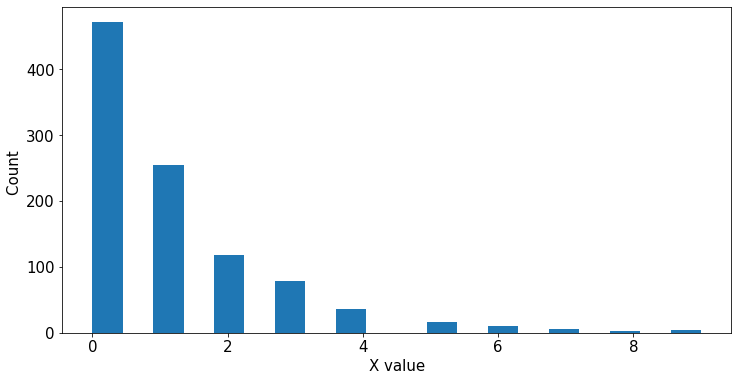

In [7]:
plt.hist(x_train, bins=20)
plt.xlabel("X value")
plt.ylabel("Count ")

# A Somewhat Naive Approach

In [8]:
def build_naive_network(n_classes):
    input_activations = L.Input(shape=[1]) 
    
    hidden_layer = L.Dense(
        units=32, #number of output channels
        activation="relu",
    )
    #calling a layer as a function applies it to the input activations
    hidden_activations = hidden_layer(input_activations)
    
    output_layer = L.Dense(
        units=n_classes,
        activation="softmax",
    )
    class_probabilities = output_layer(hidden_activations)
    
    #make the model
    model = tf.keras.models.Model(input_activations, class_probabilities)
    
    return model

# ReLU? Softmax? Whatsat?

A ReLU activation is in some sense just about the most gentle non-linearity you could imagine. It is linear almost everywhere but has a kink at 0. ReLU activations have come to be the defacto standard.

$$
ReLU(x) = max(0, x)
$$

Softmax just turns a vector of numbers both positive and negative into a vector that can be considered probabilities, which is very helpful for classification problems.
$$
{\large
softmax(x) = \frac{exp(x_{j})}{\sum_j^{N_C} exp(x_{j})}
}
$$

Every once in a while you may want to use "tanh" or "sigmoid" activations but most of the time these suffice.

In [9]:
model = build_naive_network(n_classes=n_classes)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 394
Trainable params: 394
Non-trainable params: 0
_________________________________________________________________


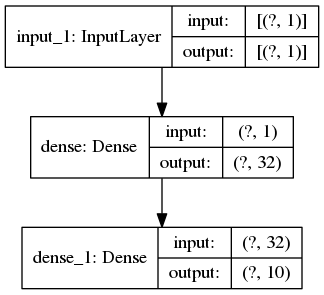

In [11]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

# Picking an Optimizer and a Loss

In [12]:
optimizer = tf.keras.optimizers.Adam() # Modern standard optimizer

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(), # typical for classification problems
    optimizer=optimizer, 
    metrics=["accuracy"], #extra numbers to track
)

# Check That The GPU Has Been Found

e.g. if you are running in a docker you need to use either the --runtime nvidia flag or the nvidia-docker command instead of docker otherwise the GPU will not be found. There may also be driver problems etc etc.

In [13]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13370115685411096310,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10671607922699612273
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10436244928
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1374095835648744634
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:41:00.0, compute capability: 6.1",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8564099187364803404
 physical_device_desc: "device: XLA_GPU device"]

# Train The Model

In [14]:
fit_history = model.fit(
    x_train,
    y_train,
    validation_data=(
        x_test,
        y_test,
    ),
    batch_size=32,
    epochs=20,
)

Epoch 1/20
32/32 [==============================] - 0s 7ms/step - loss: 2.4261 - accuracy: 0.2080 - val_loss: 2.3065 - val_accuracy: 0.0320
Epoch 2/20
32/32 [==============================] - 0s 4ms/step - loss: 2.2551 - accuracy: 0.0360 - val_loss: 2.1638 - val_accuracy: 0.0320
Epoch 3/20
32/32 [==============================] - 0s 4ms/step - loss: 2.1295 - accuracy: 0.6300 - val_loss: 2.0576 - val_accuracy: 0.7790
Epoch 4/20
32/32 [==============================] - 0s 4ms/step - loss: 2.0321 - accuracy: 0.7390 - val_loss: 1.9652 - val_accuracy: 0.7470
Epoch 5/20
32/32 [==============================] - 0s 4ms/step - loss: 1.9481 - accuracy: 0.7250 - val_loss: 1.8799 - val_accuracy: 0.7470
Epoch 6/20
32/32 [==============================] - 0s 4ms/step - loss: 1.8656 - accuracy: 0.7250 - val_loss: 1.7943 - val_accuracy: 0.7470
Epoch 7/20
32/32 [==============================] - 0s 4ms/step - loss: 1.7833 - accuracy: 0.7250 - val_loss: 1.7057 - val_accuracy: 0.7470
Epoch 8/20
32/32 [==

# Make Sure You Check Your GPU Utilization!


```nvidia-smi -l ```


The chances are very high that your GPU utilization may be low or even that you aren't using the GPU at all! I have frequently found that somehow tensorflow has quietly fallen back to CPU only and sometimes it can be difficult to tell the difference between a tough to compute model and a model that is being churned through on only the CPU. I usually don't bother with getting my GPU utilization above around 75% and often settle for just 50% or so. Squeezing that last little bit out of the GPU can often be very hard and simple changes to your data pipeline can easily tank all that hard work. 

This model is incredibly light weight and I can't get much above 10% utilization through batch size alone. Often you may need to optimize your data pipeline in some way for.

# The Importance of Broken Clocks

<img width=800 height=600 src=../images/broken-clock.jpg>

Even a broken clock is right twice a day. And your first baseline for a model should always be A constant model one whose output does not change with respect to the inputs at all. These sorts of baselines are often the most useful possible diagnostics because you can know for certain that something is wrong if your model isn't at least beating this simple baseline. What would a good categorical cross entropy for this problem be? 1.2, 0.5, 0.005? It is very hard to say problem to problem but if you know the "broken clock" model would give you the same performance as your model currently does then you know that either something is wrong or you just don't have real predictive power.

In [15]:
broken_clock_probs = np.mean(y_train, axis=0)
broken_clock_probs

array([0.471, 0.254, 0.118, 0.079, 0.036, 0.017, 0.011, 0.006, 0.003,
       0.005], dtype=float32)

In [16]:
from sklearn import metrics
metrics.log_loss(y_test,  np.ones((y_test.shape))*broken_clock_probs)

1.422876388056832

Which if the probabilities are well calibrated will be equal to the entropy of the labels!

In [17]:
def calc_entropy(p):
    return -1.0*np.sum(p*np.log(p))

In [18]:
calc_entropy(broken_clock_probs)

1.4685654640197754

So the model beats a broken clock by a factor of 2 should we consider that a win? Do we need more data? Should we try a new model architecture or data augmentation somehow?

# Tip: The "v" weights of the adam optimizer are an estimate of the running average squared gradient magnitude

In [19]:
[(w.name, w.shape, np.mean(w.numpy())) for w in optimizer.weights if "/v:" in w.name]

[('Adam/dense/kernel/v:0', TensorShape([1, 32]), 0.0021857),
 ('Adam/dense/bias/v:0', TensorShape([32]), 0.00251424),
 ('Adam/dense_1/kernel/v:0', TensorShape([32, 10]), 0.00026588986),
 ('Adam/dense_1/bias/v:0', TensorShape([10]), 0.0048605013)]

Even extremely large values or extremely small values here aren't necessarily a problem but they often can be. For example I recently was training a model where these values were all 1e-10 or smaller in nearly every layer which was related to some problems with the loss function I was using. The deeper the network usually the smaller these values are though things like batch normalization combat that somewhat.

# What did it learn?

In [20]:
def make_activation_model(net):
    activation_map = {layer.name:layer.output for layer in net.layers}
    return tf.keras.Model(net.inputs, activation_map)

In [21]:
activation_model = make_activation_model(model)
feature_maps = activation_model.predict(np.arange(10)[:, np.newaxis])

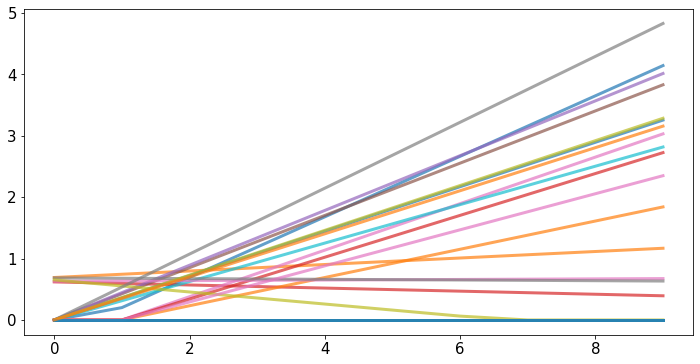

In [22]:
hidden_features = feature_maps["dense"]
for channel in range(32):
    plt.plot(hidden_features[:, channel], alpha=0.7, lw=3)

Gross! The network has learned features which are all mostly the same (common and not necessarily bad for a neural network, but 

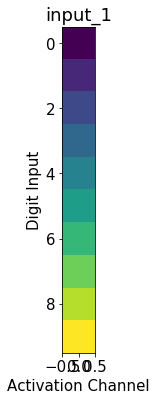

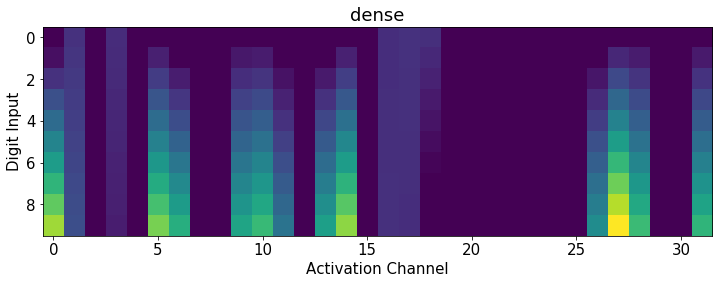

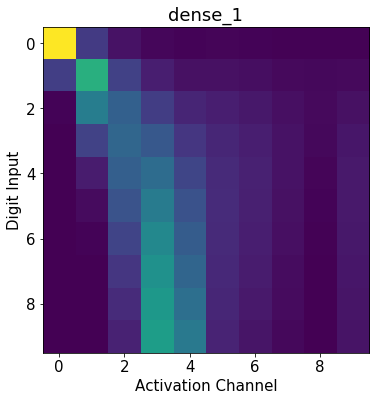

In [23]:
for name in feature_maps:
    plt.title(name)
    plt.imshow(feature_maps[name])
    plt.ylabel("Digit Input")
    plt.xlabel("Activation Channel")
    plt.show()

# About 20% Cooler

In [40]:
def build_network(
    channels, 
    n_classes,
    dropout=-1,
    vocabulary_size=None,
    embedding_dimension=None,
):
    #I like to chain activations in blocks together by overwriting "x"
    x = L.Input(shape=[1])
    input_activations = {
        "a_categorical_feature":x
    }
    
    if not (embedding_dimension is None):
        # Important Note!
        # input dimension would not normally be equal to n_classes!!!
        x = L.Embedding(input_dim=vocabulary_size, output_dim=embedding_dimension)(x)
        x = L.Reshape((embedding_dimension,))(x) #get rid of the sequence dimension
    
    for layer_idx, n_ch in enumerate(channels):
        x = L.Dense(n_ch, activation="relu")(x)
        if dropout > 0:
            x = L.Dropout(dropout)(x)
    
    class_probabilities = L.Dense(n_classes, activation="softmax")(x)
    
    #make the model
    model = tf.keras.models.Model(input_activations, class_probabilities)
    
    #compile the model
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(), #can also pass from_logits
        optimizer="adam",
        metrics=["accuracy"]
    )
    
    return model

# We Need to Go Deeper!

In [25]:
cooler_model = build_network(
    [32, 32, 32],
    n_classes=n_classes,
)

In [26]:
cooler_x_train = {"a_categorical_feature":x_train}
cooler_y_train = np.argmax(y_train, axis=1)

cooler_x_test = {"a_categorical_feature":x_test}
cooler_y_test = np.argmax(y_test, axis=1)

In [27]:
cooler_model.fit(
    cooler_x_train,
    cooler_y_train,
    validation_data=(
        cooler_x_test,
        cooler_y_test,
    ),
    batch_size=32,
    epochs=20,
)

Epoch 1/20
32/32 [==============================] - 0s 6ms/step - loss: 2.2245 - accuracy: 0.6110 - val_loss: 2.1246 - val_accuracy: 0.7470
Epoch 2/20
32/32 [==============================] - 0s 4ms/step - loss: 2.0183 - accuracy: 0.7250 - val_loss: 1.8407 - val_accuracy: 0.7470
Epoch 3/20
32/32 [==============================] - 0s 4ms/step - loss: 1.6516 - accuracy: 0.7320 - val_loss: 1.3438 - val_accuracy: 0.8120
Epoch 4/20
32/32 [==============================] - 0s 4ms/step - loss: 1.1237 - accuracy: 0.7840 - val_loss: 0.8330 - val_accuracy: 0.7470
Epoch 5/20
32/32 [==============================] - 0s 4ms/step - loss: 0.7578 - accuracy: 0.7600 - val_loss: 0.5929 - val_accuracy: 0.7470
Epoch 6/20
32/32 [==============================] - 0s 4ms/step - loss: 0.5988 - accuracy: 0.7890 - val_loss: 0.4770 - val_accuracy: 0.8650
Epoch 7/20
32/32 [==============================] - 0s 4ms/step - loss: 0.4962 - accuracy: 0.8690 - val_loss: 0.4015 - val_accuracy: 0.9300
Epoch 8/20
32/32 [==

In [28]:
cooler_activation_model = make_activation_model(cooler_model)
cooler_feature_maps = cooler_activation_model.predict(np.arange(10)[:, np.newaxis])

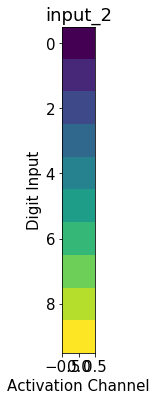

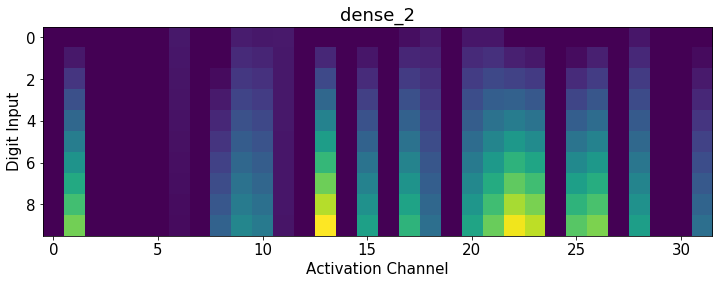

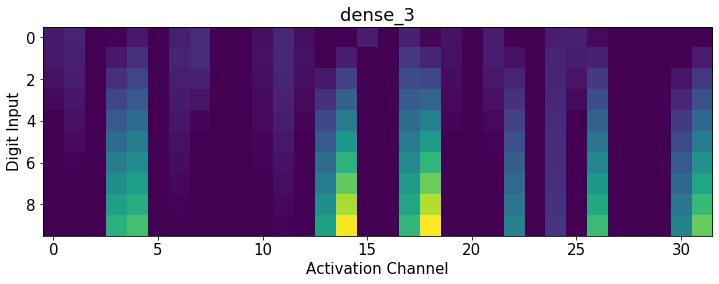

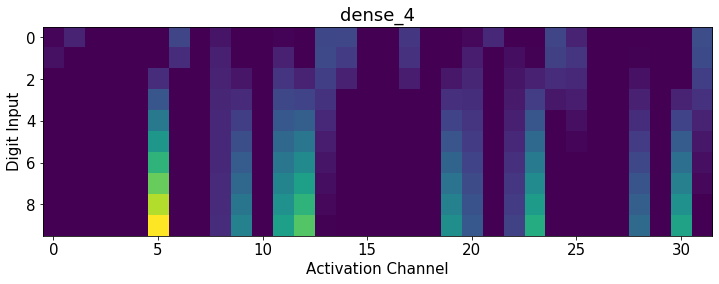

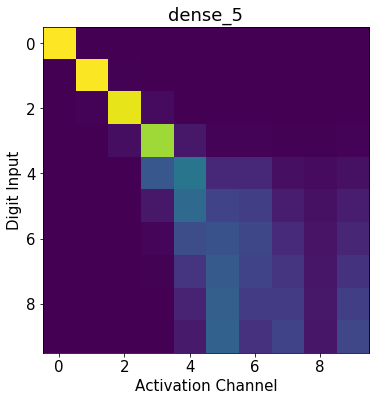

In [29]:
for name in cooler_feature_maps:
    plt.title(name)
    plt.imshow(cooler_feature_maps[name])
    plt.ylabel("Digit Input")
    plt.xlabel("Activation Channel")
    plt.show()

# Categoricals --> Embeddings

But Really we are making the problem too hard on ourselves, Encoding a categorical variable as a scalar variable just because it happens to be an integer is really bad form. The proper way to deal with that input is to put it through an embedding layer. This is more or less equivalent to onehot encoding it and then putting the one hot encoded vector through one dense layer. But it is much much more efficient.

In [41]:
embedding_model = build_network(
    [32,],
    n_classes=n_classes,
    vocabulary_size=n_classes,
    embedding_dimension=32,
)

In [42]:
embedding_model.fit(
    cooler_x_train,
    cooler_y_train,
    validation_data=(
        cooler_x_test,
        cooler_y_test,
    ),
    batch_size=32,
    epochs=20,
)

Epoch 1/20
32/32 [==============================] - 0s 6ms/step - loss: 2.1738 - accuracy: 0.4710 - val_loss: 2.0211 - val_accuracy: 0.4720
Epoch 2/20
32/32 [==============================] - 0s 4ms/step - loss: 1.8077 - accuracy: 0.6280 - val_loss: 1.4943 - val_accuracy: 0.8120
Epoch 3/20
32/32 [==============================] - 0s 4ms/step - loss: 1.1978 - accuracy: 0.9070 - val_loss: 0.8669 - val_accuracy: 0.9300
Epoch 4/20
32/32 [==============================] - 0s 4ms/step - loss: 0.6900 - accuracy: 0.9530 - val_loss: 0.4789 - val_accuracy: 0.9860
Epoch 5/20
32/32 [==============================] - 0s 4ms/step - loss: 0.3819 - accuracy: 0.9750 - val_loss: 0.2572 - val_accuracy: 0.9860
Epoch 6/20
32/32 [==============================] - 0s 4ms/step - loss: 0.2228 - accuracy: 0.9800 - val_loss: 0.1585 - val_accuracy: 0.9880
Epoch 7/20
32/32 [==============================] - 0s 4ms/step - loss: 0.1513 - accuracy: 0.9810 - val_loss: 0.1093 - val_accuracy: 0.9880
Epoch 8/20
32/32 [==

In [43]:
embedding_activation_model = make_activation_model(embedding_model)
embedding_feature_maps = embedding_activation_model.predict(np.arange(10)[:, np.newaxis])

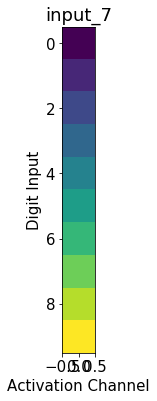

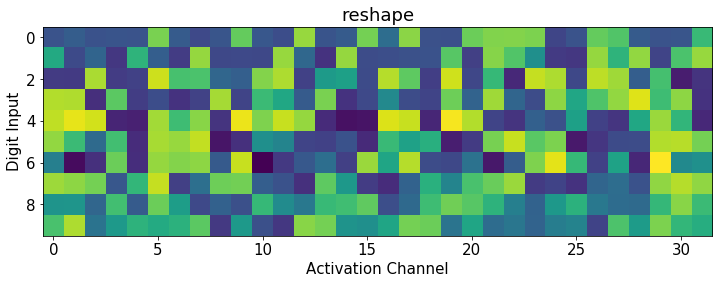

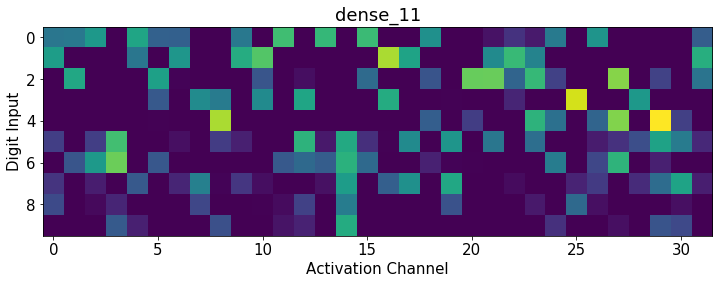

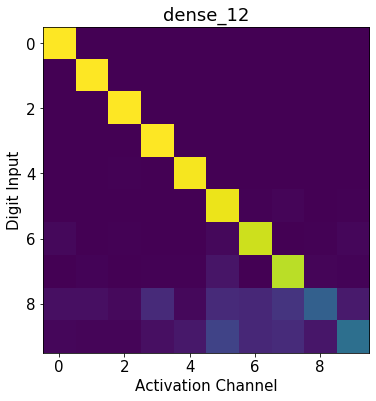

In [49]:
for name in embedding_feature_maps:
    fmap = embedding_feature_maps[name]
    if len(fmap.shape) != 2:
        continue
    plt.title(name)
    plt.imshow(fmap)
    plt.ylabel("Digit Input")
    plt.xlabel("Activation Channel")
    plt.show()